# <u>Project Title: The 50K Income Classification Project by SotMethMeth</u>
## __Table of Contents:__
* #### [Section 1: Project Dependencies](#part1)
* #### [Section 2: Exploratory Data Analysis (EDA)](#part2)
* #### [Section 3: Data pre-processing](#part3)
* #### [train-validate sets are here](#trainval)
* #### [Section 4: Short-listing of candidate machine learning models](#part4)
* #### [Section 5: Fine-tuning of hyperparameters](#part5)
* #### [Section 6: Feature selection and explanability](#part6)
* #### [Section 7: Potential improvements](#part7)

***
<a id="part1"></a>
### <u>Section 1: Project Dependencies</u>


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer # ported to sklearn from fancyimpute
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from category_encoders import CatBoostEncoder
from tpot import TPOTClassifier
# from espressomaker import Espresso
import xgboost as xgb
from hyperopt import hp, fmin, tpe
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib

%config InlineBackend.figure_format = 'retina'

***
<a id="part2"></a>
### Section 2: Exploratory Data Analysis (EDA)

In [84]:
df = pd.read_csv('train.csv')

In [85]:
df_test = pd.read_csv('test.csv')

In [86]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,exceeds50K
0,30,?,147215,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States,0
1,60,Private,173960,Bachelors,13,Divorced,Prof-specialty,Not-in-family,Female,0,0,42,United-States,0
2,52,?,105428,Some-college,10,Married-civ-spouse,?,Husband,Male,0,0,12,United-States,0
3,37,Private,112497,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,0,0,60,United-States,0
4,63,Private,137843,Some-college,10,Married-civ-spouse,Sales,Husband,Male,7298,0,48,United-States,1


In [87]:
df.shape

(24421, 14)

In [88]:
# We can see that we have 2 main types of data: int64 and object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24421 non-null  int64 
 1   workclass       24421 non-null  object
 2   fnlwgt          24421 non-null  int64 
 3   education       24421 non-null  object
 4   education-num   24421 non-null  int64 
 5   marital-status  24421 non-null  object
 6   occupation      24421 non-null  object
 7   relationship    24421 non-null  object
 8   sex             24421 non-null  object
 9   capital-gain    24421 non-null  int64 
 10  capital-loss    24421 non-null  int64 
 11  hours-per-week  24421 non-null  int64 
 12  native-country  24421 non-null  object
 13  exceeds50K      24421 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 2.6+ MB


In [89]:
df.rename(columns={"exceeds50K":"class"}, inplace=True)

In [90]:
df.describe() # this is applicable to numeric columns
# We can see that our features are of very different scales.

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class
count,24421.000000,2.442100e+04,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000
mean,38.587036,1.888204e+05,10.096515,1116.029974,86.547643,40.511609,0.239998
std,13.677055,1.046917e+05,2.574488,7646.590185,399.096945,12.367526,0.427091
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175830e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.778240e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.365860e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3900.000000,99.000000,1.000000


#### Exploration of numeric features:

In [91]:
numerical = df.select_dtypes(include = ['int64'])

C:\Users\ngken\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ngken\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ngken\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ngken\anaconda3\lib\site-packages\pandas\plotting\_matpl

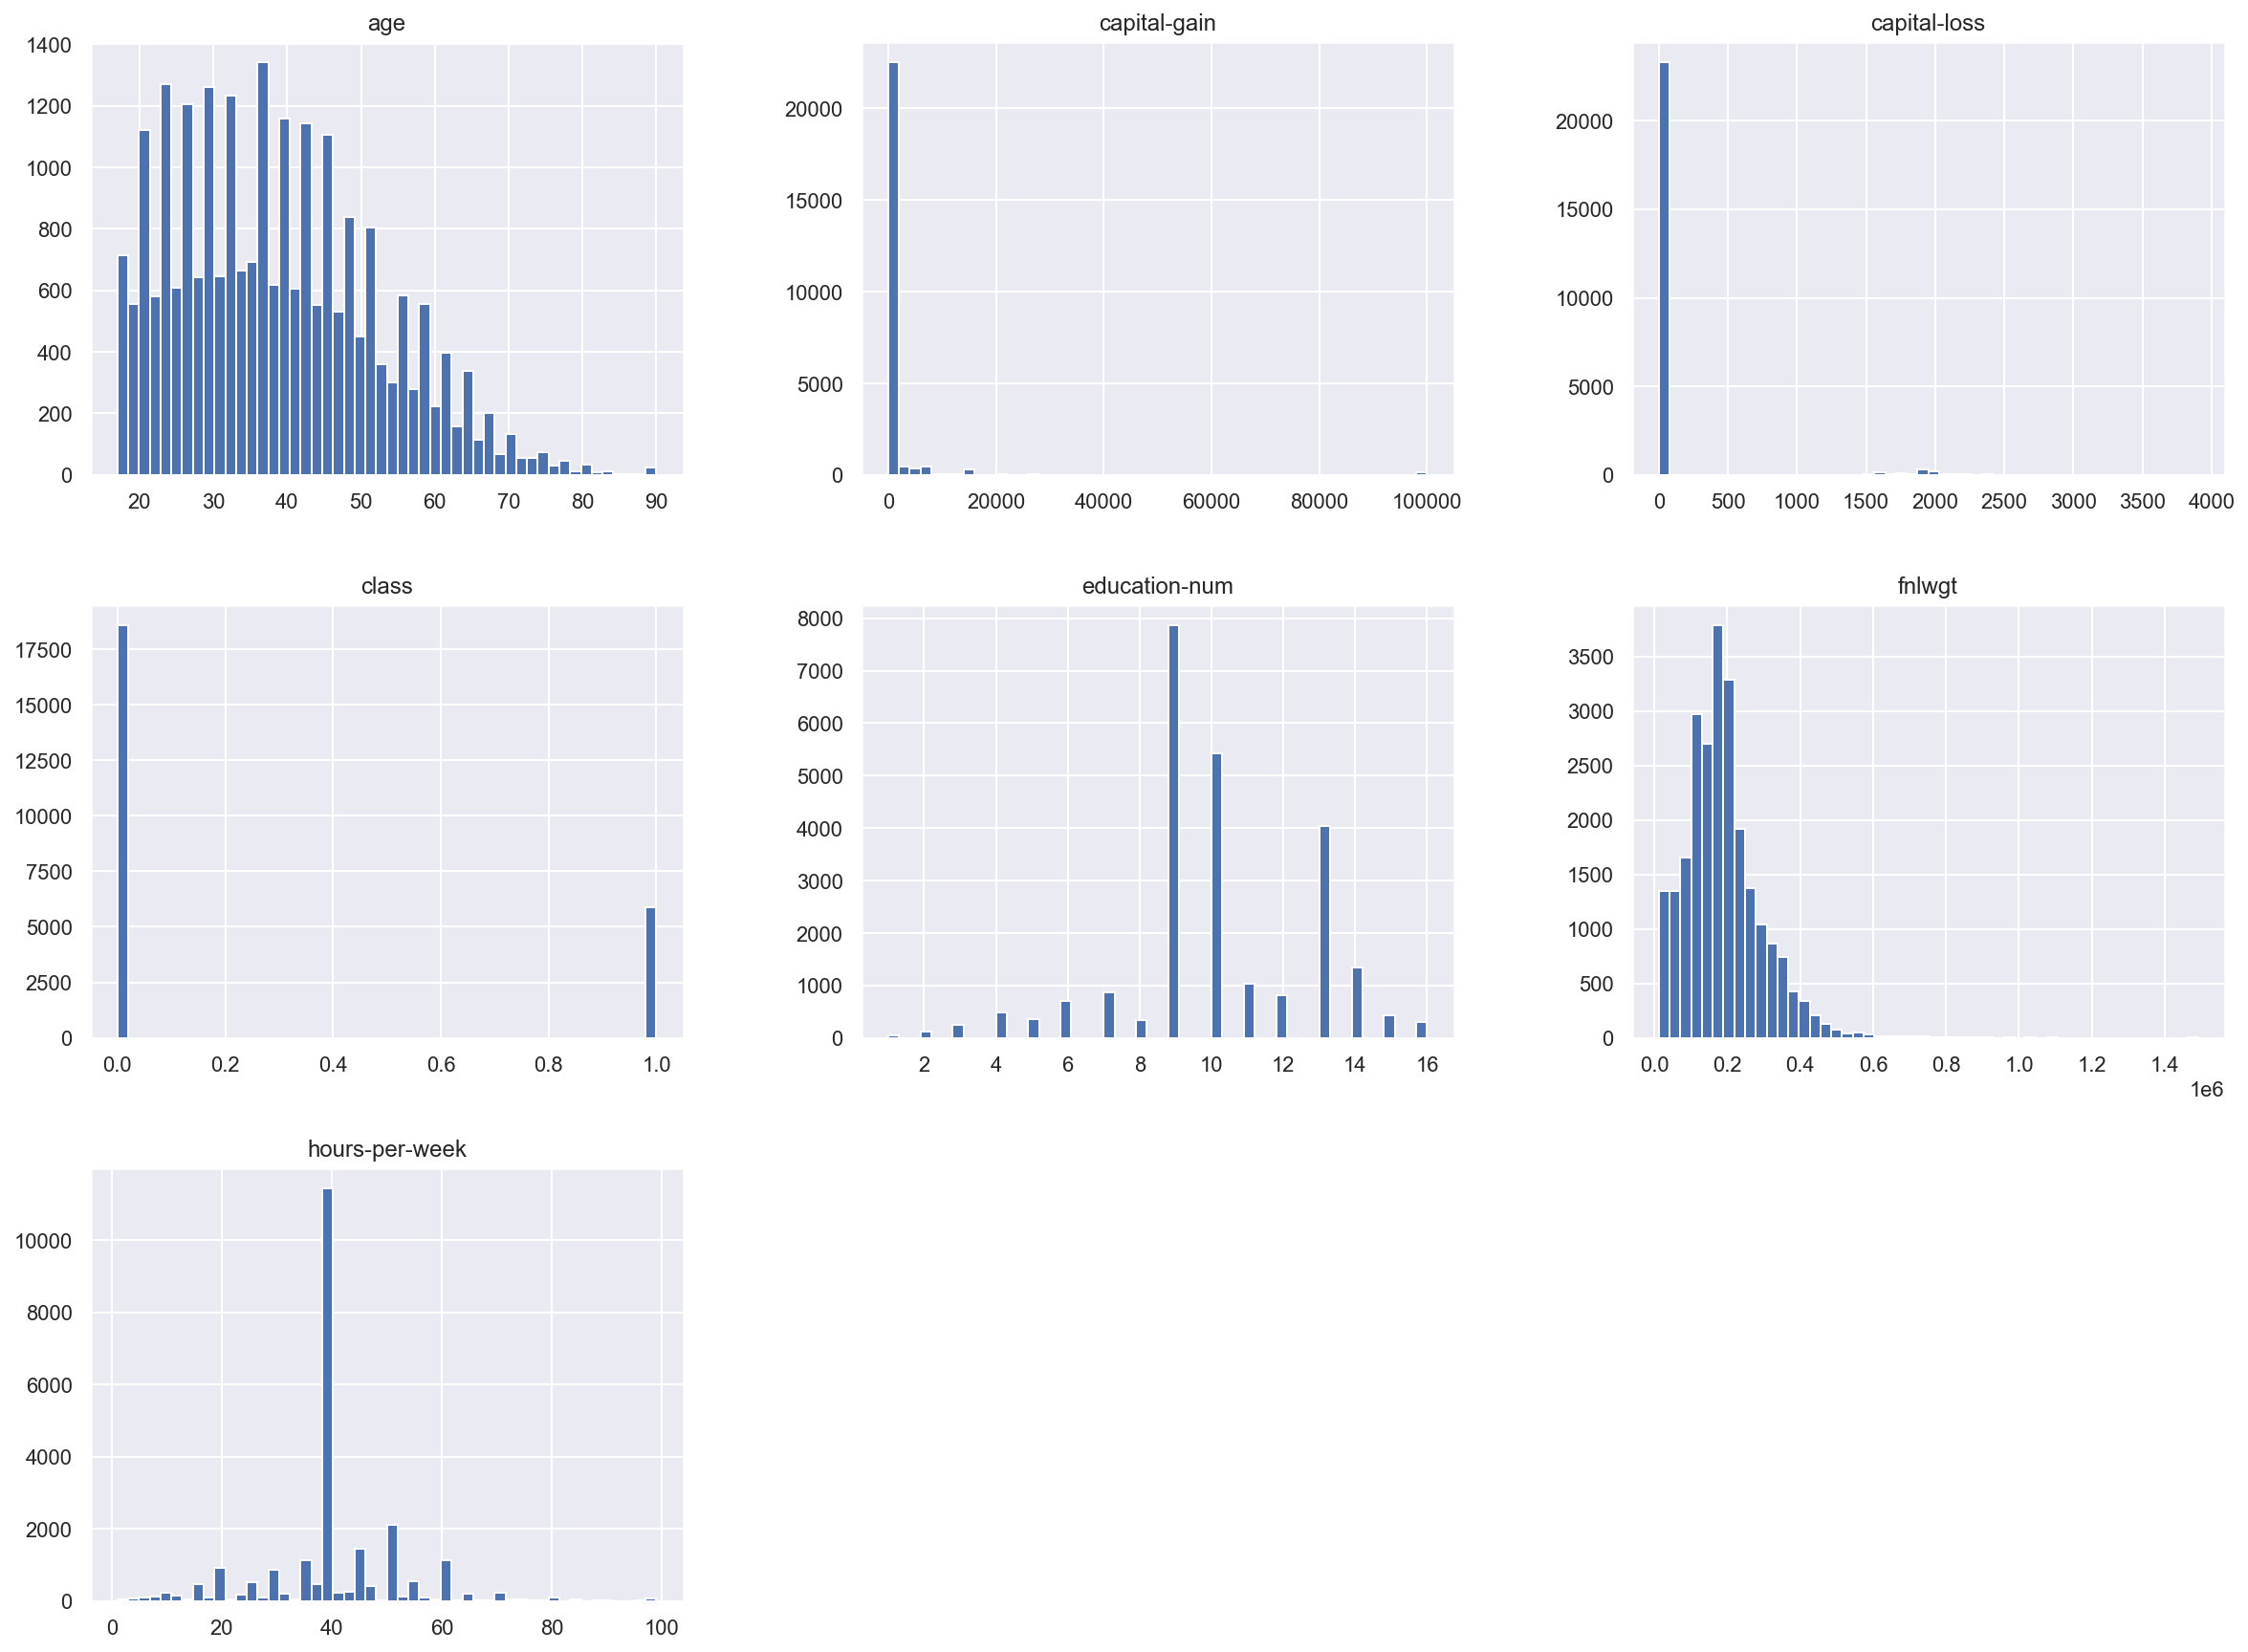

In [92]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

Some observations for above numerical plots:
1. Capital-gain and capital-loss: Values are very skewed, we just care whether there were investments done.
2. Class is imbalanced, optimizing for AUC does not sound like a good idea.
3. Education-num and hours-per-week looks roughly normally distributed.
4. Hours-per-week looks like there are some outliers. 
5. fnlwgt looks right-tail heavy, may want to consider doing some log transformations.

In [93]:
numerical_cols = list(set(numerical.columns) - set(['class']))

In [94]:
numerical_cols

['age',
 'hours-per-week',
 'capital-loss',
 'education-num',
 'capital-gain',
 'fnlwgt']

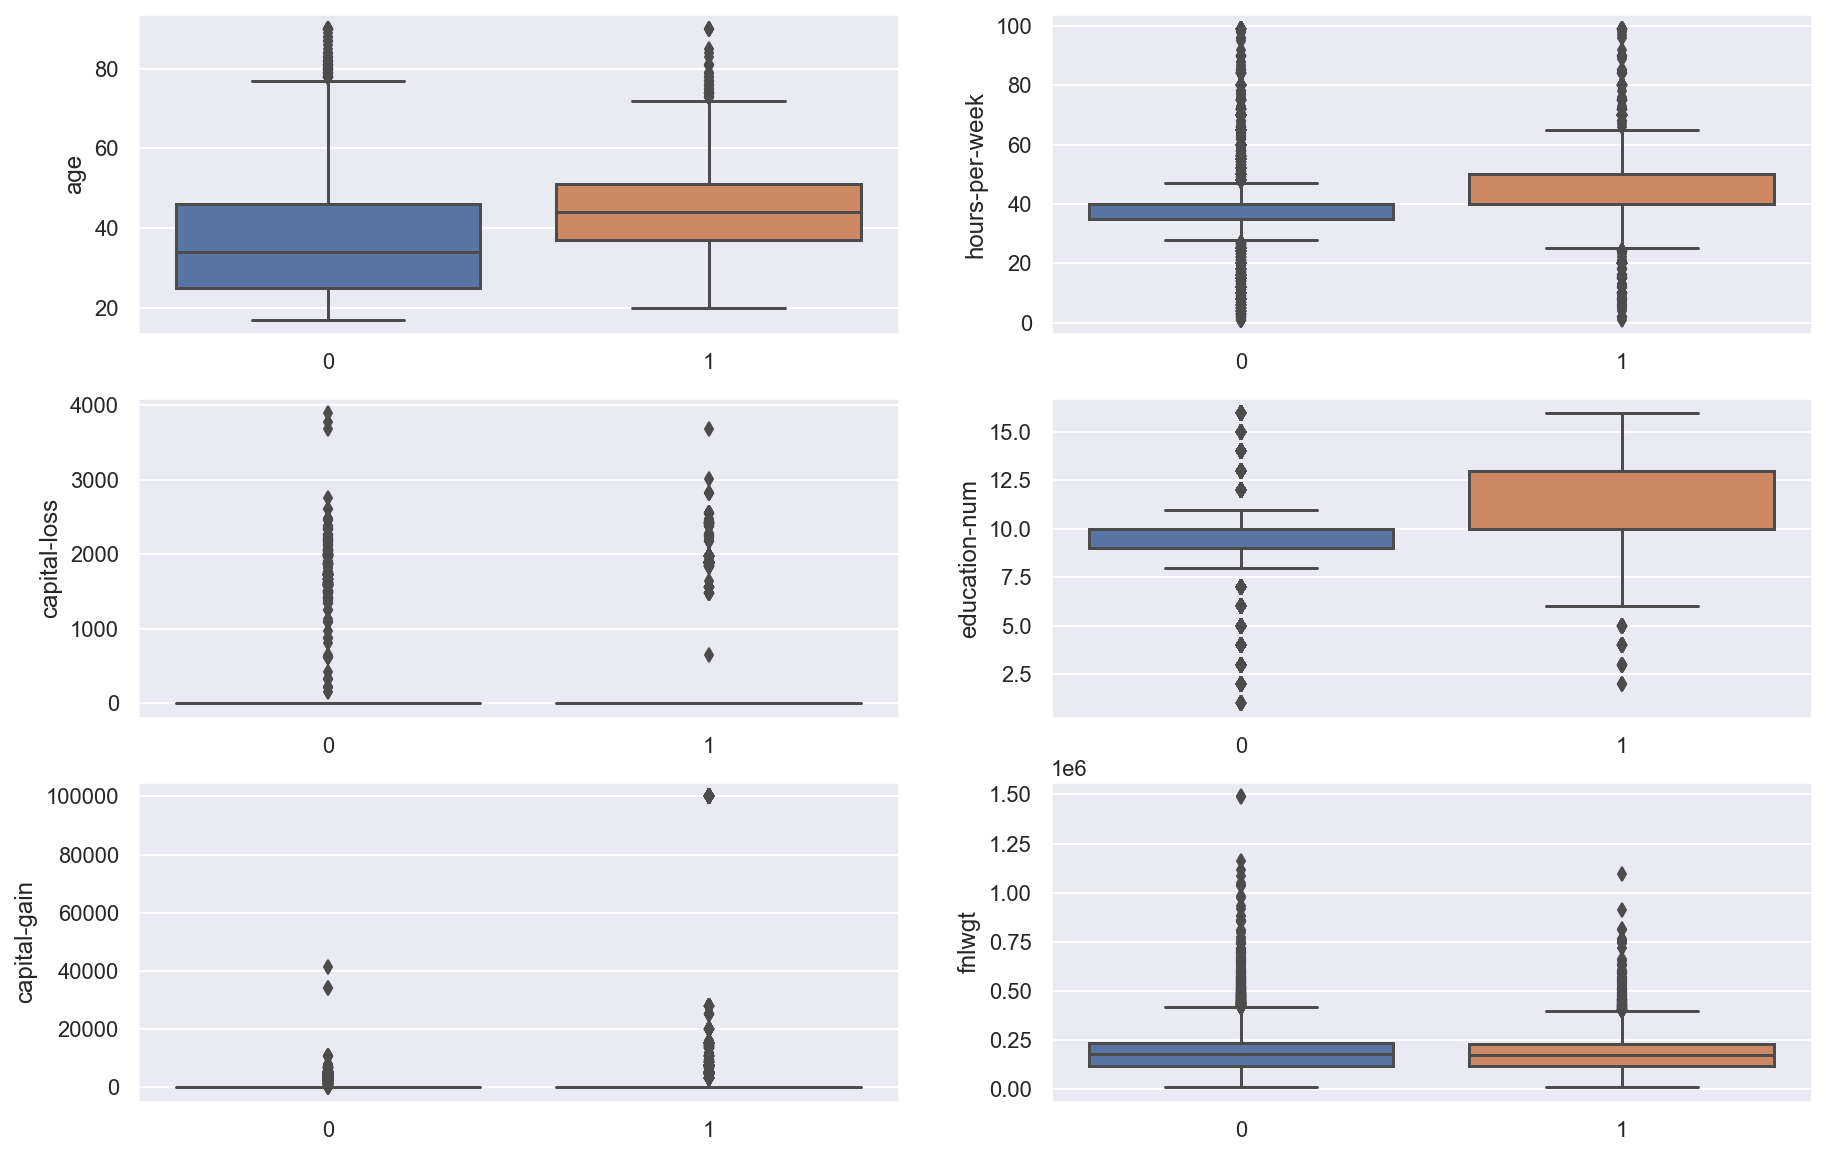

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,10))
for idx, feat in enumerate(numerical_cols):
    ax = axes[int(idx/2), idx%2]
    sns.boxplot(x='class',y=feat, data=df,ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
plt.show()

It is clear that we have 3 important numerical features which have discriminative power for classification: **education-num, hours-per-week and age.** What does this imply, when we do the train-test split, we should make sure our splits also have a fair distribution over these categories. 

We can further confirm this using Point Biserial Correlation:

In [ ]:
numerical.corr()

#### Exploration of categorical features:

In [96]:
categorical = df.select_dtypes(include = ['object'])

In [97]:
categorical.info()

# We note that education is just a discrete representation of our education-num
# feature, we should not have duplicate information, and just drop education. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       24421 non-null  object
 1   education       24421 non-null  object
 2   marital-status  24421 non-null  object
 3   occupation      24421 non-null  object
 4   relationship    24421 non-null  object
 5   sex             24421 non-null  object
 6   native-country  24421 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


In [98]:
categorical_cols = list(set(categorical.columns) - set(['education']))

In [ ]:
for cat in categorical_cols:
    print("Number of levels in category '{0}': \b {1:2}".format(cat, df[cat].unique().size))

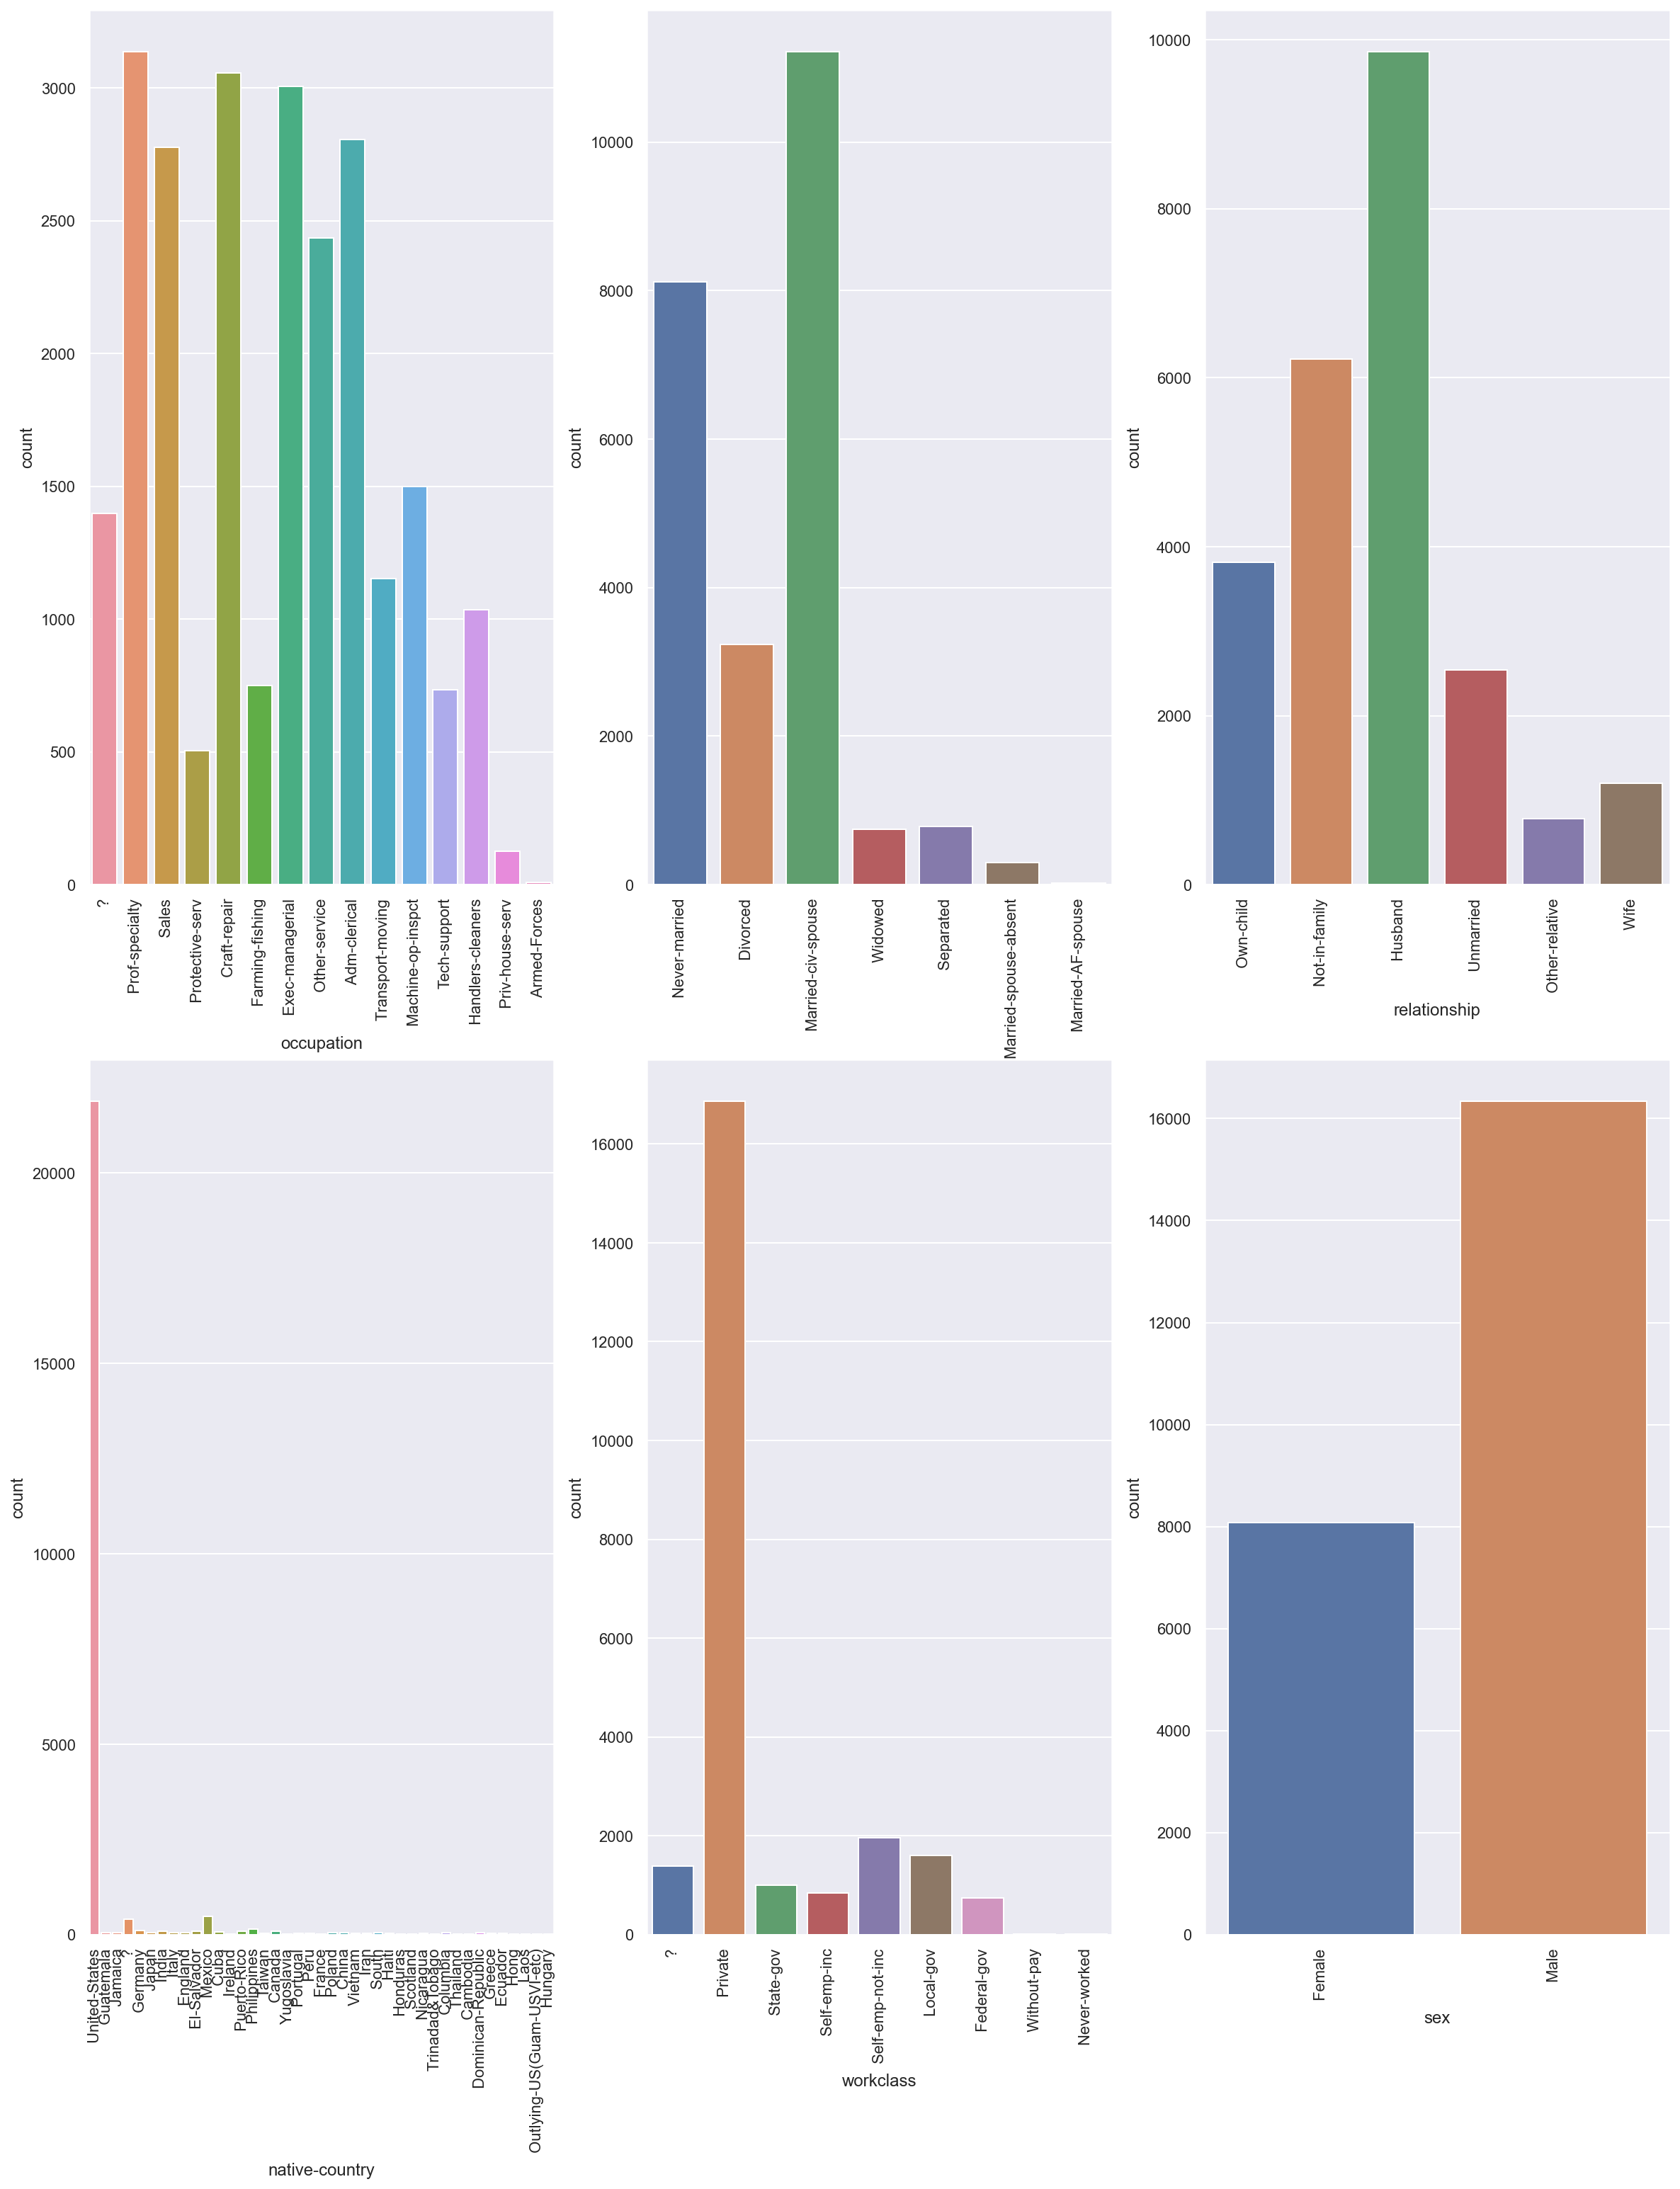

In [100]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,25))
for idx, feat in enumerate(categorical_cols):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(x=feat, data=df,ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel(feat)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

Some conclusions about the above plots:

Notably, we see that in the native-country field, the U.S count is exceptionally skewed. For plotting purposes, given that we have too many categories for nationality, we will not plot the countplot for the nationality feature. Let us do a simple countplot for the other features.

<b> We plot our categorical features grouped on our target variable. </b>

In [101]:
categorical_cols_toplot = ['relationship', 'occupation', 'workclass',
                          'sex', 'marital-status']

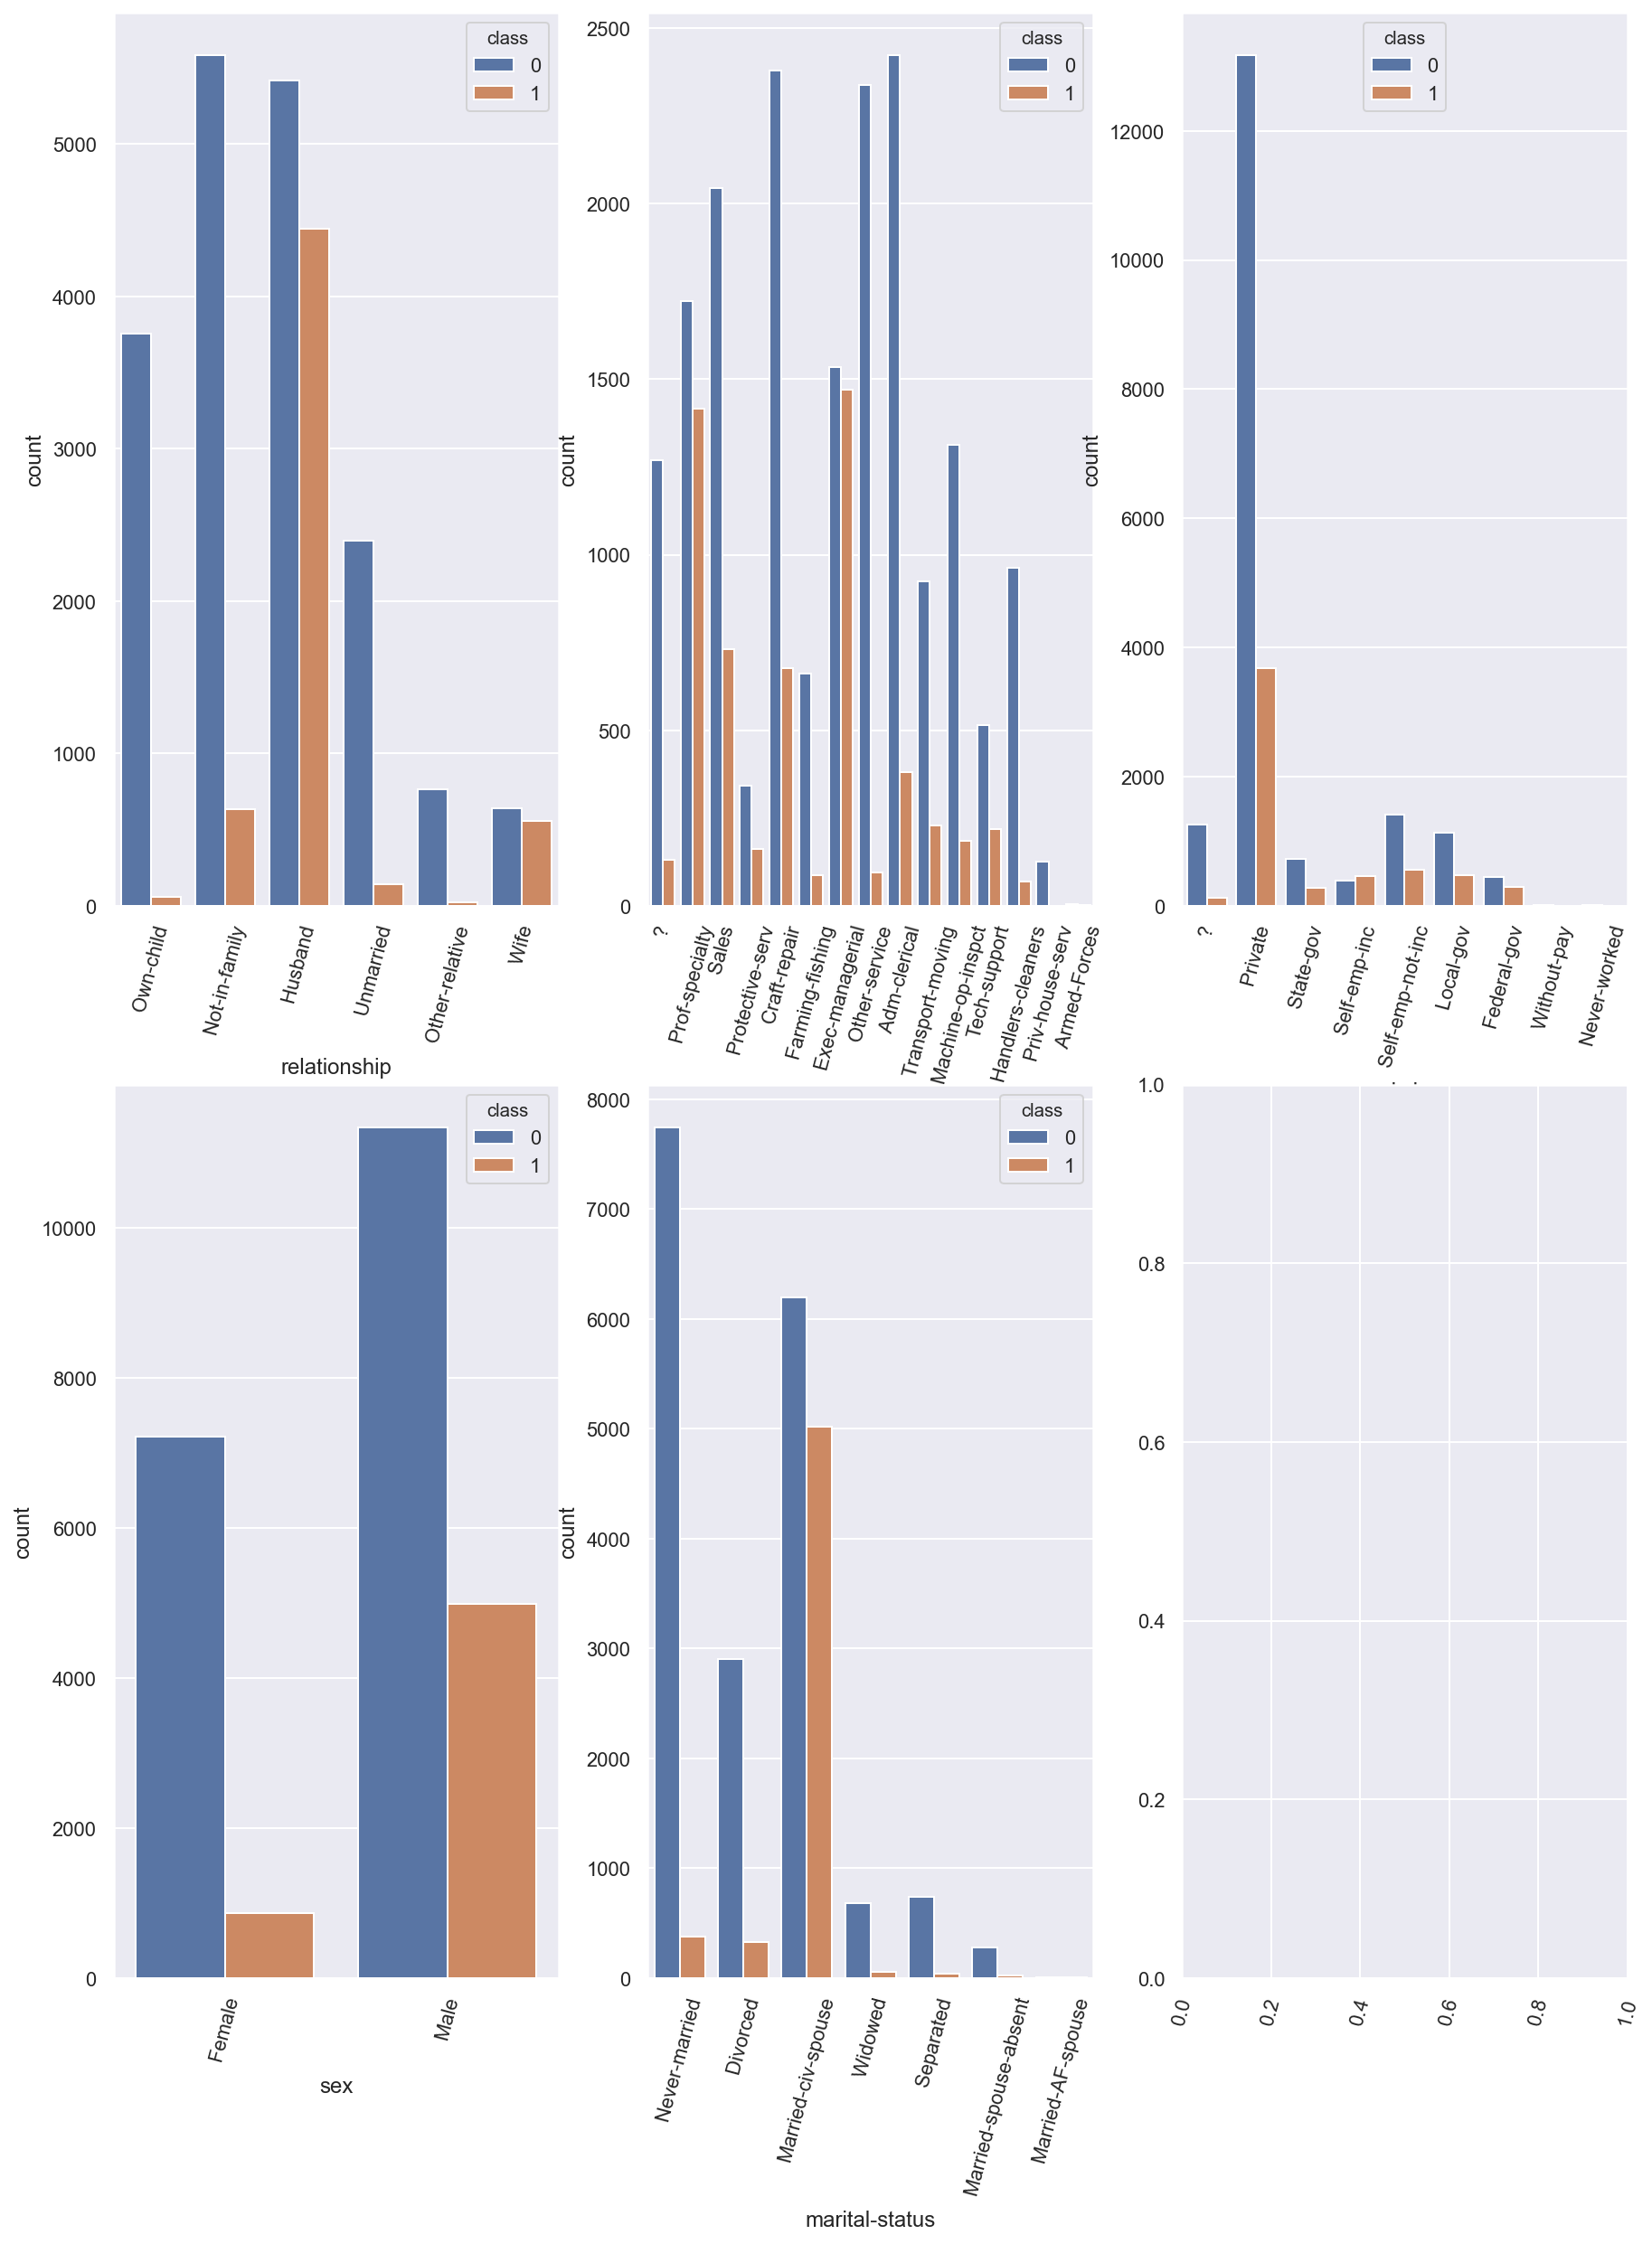

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,20))
for idx, feat in enumerate(categorical_cols_toplot):
    ax = axes[int(idx/3), idx%3]
    sns.countplot(df[feat], hue=df['class'],ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel(feat)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=75)
plt.show()

Some interesting observations:
1. Males have a higher proportion earning > 50K.
2. The relationship variable and marital-status are painting the same picture that a large proportion of married-civ-spouse (husbands and wives) are generally earning more than 50K.
3. Generally all categorical features are influential in determining target variable.

<b>For the native-country feature </b>, instead of doing a countplot, we can consider doing a contigency table to understand if nationality does indeed affect our target variable. We should expect the ratios of our target variable to be about constant across the different nationalities, should nationality not be important.

We can see that countries such as Taiwan and Japan have a much higher proportion of '1' labels as compared to the other countries. It is clear that native-country does indeed influence the probability of the target variable. 

In [103]:
pd.crosstab(df['native-country'], df['class'], margins = 'index').sort_values(by = [1], ascending=False)

class,0,1,All
native-country,,,
All,18560,5861,24421
United-States,16542,5341,21883
?,300,110,410
Philippines,106,40,146
India,44,36,80
Canada,57,29,86
Germany,79,29,108
Mexico,458,24,482
England,35,23,58


***
<a id="part3"></a>
### Section 3: Data pre-processing
#### <u>Step 1: Removing duplicates</u>
We should remove duplicates from our dataset. We can see where the duplicates are using the following command.

In [104]:
df[df.duplicated(subset = list(set(df.columns) - set(['class'])), keep = False)].sort_values(by = list(df.columns))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,class
22391,17,Private,153021,12th,8,Never-married,Sales,Own-child,Female,0,0,20,United-States,0
22798,17,Private,153021,12th,8,Never-married,Sales,Own-child,Female,0,0,20,United-States,0
867,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Male,0,0,40,United-States,0
11256,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Male,0,0,40,United-States,0
5772,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,Female,0,0,10,United-States,0
12743,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,Female,0,0,10,United-States,0
11769,19,Private,139466,Some-college,10,Never-married,Sales,Own-child,Female,0,0,25,United-States,0
19623,19,Private,139466,Some-college,10,Never-married,Sales,Own-child,Female,0,0,25,United-States,0
13105,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,Male,0,0,14,United-States,0
21624,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,Male,0,0,14,United-States,0


We can proceed to drop the duplicated rows by simply doing the following:

In [105]:
df.drop_duplicates(subset = list(set(df.columns) - set(['class'])), keep='first',inplace=True)

Verify that we do not have any duplicated rows left.

In [106]:
df[df.duplicated(subset = list(set(df.columns) - set(['class'])), keep = False)].sort_values(by = list(df.columns))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,class


#### <u>Step 2: Scaling</u>
We should ensure that our numerical features are scaled using <b>StandardScaler</b>.

In [107]:
df_numerical = df.select_dtypes(['int64'])
df_test_numerical = df_test.select_dtypes(['int64'])

In [109]:
df_numerical.drop('class', axis=1, inplace=True)

C:\Users\ngken\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [127]:
df_numerical

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,30,147215,10,0,0,30
1,60,173960,13,0,0,42
2,52,105428,10,0,0,12
3,37,112497,13,0,0,60
4,63,137843,10,7298,0,48
...,...,...,...,...,...,...
24416,44,104196,14,0,0,45
24417,52,112959,10,0,0,40
24418,50,263200,11,0,0,40
24419,25,228608,10,0,0,40


In [112]:
ss = StandardScaler()
df_scaled_values = ss.fit_transform(df_numerical)
df_test_scaled_values = ss.transform(df_test_numerical)

In [167]:
df_numerical_scaled = pd.DataFrame(data = df_scaled_values, columns = df_numerical.columns)

###### Test set equivalent ######
df_test_numerical_scaled = pd.DataFrame(data = df_test_scaled_values, columns = df_test_numerical.columns)

In [168]:
df.drop(list(df_numerical.columns), axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)
df_final = pd.concat([df,df_numerical_scaled], axis=1)

###### Test set equivalent ######
df_test.drop(list(df_test_numerical.columns), axis=1, inplace=True)
X_test = pd.concat([df_test,df_test_numerical_scaled], axis=1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-1.140037,-1.490679,-0.037649,-0.146009,-0.216947,-1.254471
1,2.223314,-0.227231,-0.426125,0.185790,-0.216947,-0.041648
2,-0.847572,-1.455264,1.127779,-0.146009,-0.216947,-0.041648
3,0.102941,-0.062955,-0.037649,-0.146009,-0.216947,-0.041648
4,-1.066921,-0.949952,-1.203077,-0.146009,-0.216947,-0.041648
...,...,...,...,...,...,...
24416,-0.920688,-0.760470,-0.037649,-0.146009,-0.216947,0.766900
24417,0.980336,0.629136,-0.426125,-0.146009,-0.216947,4.728787
24418,0.102941,-0.693308,-0.037649,-0.146009,-0.216947,0.362626
24419,-0.701339,0.615592,-0.037649,-0.146009,-0.216947,-0.041648


#### <u>Step 3: A more 'refined' train-holdout-split:</u>

We know from earlier EDA that we have `education-num` to be important in predicting if income >= 50K. We will consider discretizing the continuous variable into categories, so that our train-test split can be representative.

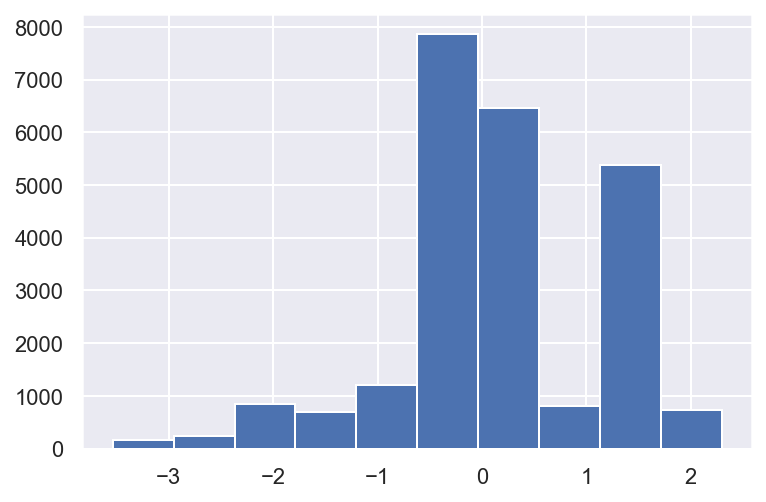

In [138]:
df_final['education-num'].hist()

In [149]:
df_final['education-cat'] = pd.cut(df_final['education-num'], bins = [-np.inf, -2., -1., 0, 2., np.inf], 
                             labels = [1,2,3,4,5])

In [150]:
df_final['education-cat'].value_counts()

3    13606
4     7666
2     1930
1      899
5      302
Name: education-cat, dtype: int64

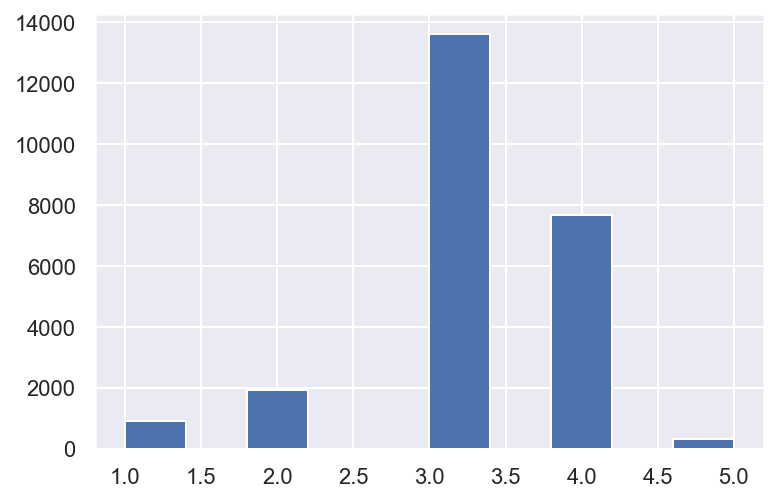

In [151]:
df_final['education-cat'].hist()

In [154]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_final, df_final["education-cat"]):
    strat_train_set = df_final.loc[train_index]
    strat_test_set = df_final.loc[test_index]

In [155]:
strat_test_set['education-cat'].value_counts() / len(strat_test_set)

3    0.557673
4    0.314075
2    0.079082
1    0.036878
5    0.012293
Name: education-cat, dtype: float64

In [156]:
df_final['education-cat'].value_counts() / len(df_final)

3    0.557554
4    0.314142
2    0.079089
1    0.036840
5    0.012376
Name: education-cat, dtype: float64

In [157]:
def education_cat_proportions(data):
    return data['education-cat'].value_counts() / len(data)

train_set, test_set = train_test_split(df_final, test_size = 0.2, random_state = 42)

compare_props = pd.DataFrame({
    "Overall": education_cat_proportions(df_final),
    "Stratified": education_cat_proportions(strat_test_set),
    "Random": education_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
'''
We can see that this custom train-holdout-split allows for a more representative train-holdout split based on
the educational years feature.
'''
compare_props

In [159]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('education-cat', axis=1, inplace=True)

<a id="trainval"></a>
train-validate here, can just pd.read_csv from our github codes here.

In [285]:
# train-validate sets are here.
X_train = strat_train_set.copy() # pd.read_csv('df_train_v2.csv')
X_val = strat_test_set.copy() # pd.read_csv('df_val_v2.csv')

#### <u>Step 4: Missing rows in our training dataset:</u>

We proceed to also clean for missing rows. Earlier on while we were doing our EDA, it was noteworthy to point out that some of the features: `native-country`, `occupation`, `workclass` had ' ?' to indicate they were missing. Let us take a look at some of these entries.

In [287]:
bool_mask = X_train.select_dtypes([np.object]).apply(lambda x: x.str.contains('\?'), axis = 1).any(axis = 1)

In [288]:
X_train[bool_mask] # we can see 1417 rows which have a question mark in them.

,workclass,education,marital-status,occupation,relationship,sex,native-country,class,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
3324,?,HS-grad,Never-married,?,Own-child,Female,United-States,0,-1.505619,0.879571,-0.426125,-0.146009,-0.216947,-2.063019
13607,?,HS-grad,Never-married,?,Unmarried,Female,United-States,0,-0.189525,-0.007884,-0.426125,-0.146009,-0.216947,-0.041648
992,?,HS-grad,Widowed,?,Not-in-family,Female,United-States,0,2.662012,0.360878,-0.426125,-0.146009,-0.216947,-1.658745
8624,?,Some-college,Never-married,?,Own-child,Male,United-States,0,-1.432502,-0.864604,-0.037649,-0.146009,-0.216947,-0.688487
13732,Private,Some-college,Never-married,Sales,Unmarried,Female,?,0,-0.920688,0.522929,-0.037649,-0.146009,-0.216947,-0.041648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22570,?,Assoc-voc,Separated,?,Unmarried,Female,Mexico,0,-0.774455,0.074703,0.350827,-0.146009,-0.216947,-0.041648
3687,?,HS-grad,Married-civ-spouse,?,Husband,Male,United-States,0,0.322290,2.771338,-0.426125,-0.146009,-0.216947,0.766900
2925,?,Bachelors,Divorced,?,Not-in-family,Female,United-States,0,0.102941,-0.255015,1.127779,-0.146009,-0.216947,0.766900
16420,?,12th,Never-married,?,Not-in-family,Male,United-States,0,-1.213153,-0.964087,-0.814601,-0.146009,-0.216947,-0.850197


In [289]:
X_train = X_train.replace(to_replace='.*\?', value=np.nan, regex=True)
X_val = X_val.replace(to_replace='.*\?', value=np.nan, regex=True)

In [290]:
X_test = X_test.replace(to_replace='.*\?', value=np.nan, regex=True)

In [291]:
X_train.isnull().any() # We can see that we have missing values in the 3 columns as discussed.

workclass          True
education         False
marital-status    False
occupation         True
relationship      False
sex               False
native-country     True
class             False
age               False
fnlwgt            False
education-num     False
capital-gain      False
capital-loss      False
hours-per-week    False
dtype: bool

In [292]:
y_train = X_train['class']
y_val = X_val['class']

In [293]:
X_train.drop('class', inplace=True, axis=1)
X_val.drop('class', inplace=True, axis=1)

#### Step 4: Feature Engineering
We note that in the earlier EDA, we have discussed that we want to remove some columns: `education`, `fnlwgt`. We also should consider doing some engineering on our capital-gain and capital-loss features to be one of the two values: 1 for investor, 0 for non-investor.


https://brendanhasz.github.io/2019/03/04/target-encoding.html#target-encoding
https://github.com/EpistasisLab/tpot/blob/master/tutorials/MAGIC%20Gamma%20Telescope/MAGIC%20Gamma%20Telescope.ipynb
https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
https://www.kaggle.com/residentmario/encoding-categorical-data-in-sklearn


#### AttributesRemover:

In [294]:
X_train_copy = X_train.copy()

#### AttributesAdder:

In [295]:
'''
Grouped marriage feature into binary variable, and binarized the capital feature from capital-gain
and capital-loss.
'''
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['marital-status'] = X['marital-status'].map({' Never-married': 'Single', ' Divorced': 'Single', ' Widowed': 'Single',
                              ' Married-civ-spouse': 'Married', ' Married-spouse-absent': 'Married',
                              ' Married-AF-spouse': 'Married', ' Never-married': 'Single', ' Separated': 'Single'})
        def mapper(x):
            if x['capital-gain'] == -0.14600928018106676 and x['capital-loss'] == -0.21694686573519104:
                return 0
            else:
                return 1
        
        X['capital'] = X.apply(mapper, axis=1)
        X.drop(['capital-gain', 'capital-loss', 'education'], inplace=True,axis=1)
        return X

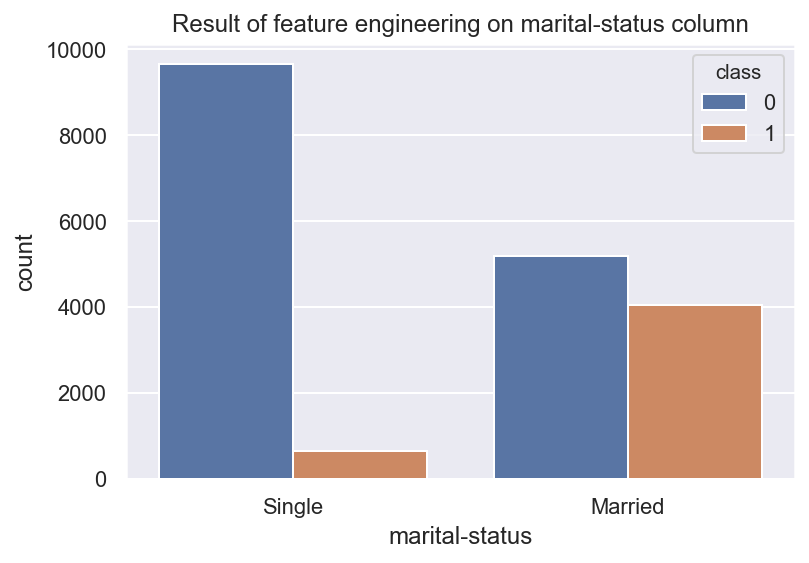

In [296]:
sns.countplot(testt['marital-status'], hue=y_train)
plt.title('Result of feature engineering on marital-status column')
plt.show() #

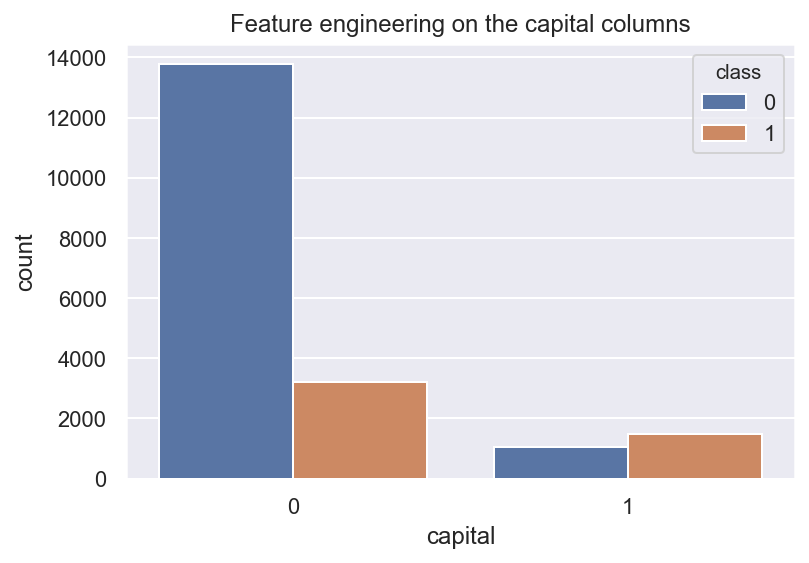

In [297]:
sns.countplot(testt['capital'], hue=y_train)
plt.title('Feature engineering on the capital columns')
plt.show()

In [298]:
'''
We choose to do one-hot encoding for categorical features which are low in cardinality. 
This is because mean target encoding may not work well for these features - Source: Kaggle.
'''
class OneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.cols = columns
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = pd.get_dummies(data=X, columns=self.cols)
        return X

# oht = OneHotTransformer(['sex', 'marital-status'])
# testtt = oht.transform(testt)

In [299]:
'''
Adapted from https://brendanhasz.github.io/2019/03/04/target-encoding.html#target-encoding
Custom transformer for Mean Target Encoder.
'''
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.
    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        

    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
      
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

## Summary of Keng Hwee's work:
1. Transformers as above so that I can write everything in one simple pipeline: Feature engineering, and pipeline objects.
2. Research on categorical encoders and smarter imputations.
3. Tried out popular tree-based models and autoML (TPOT gg).
4. Hyperparameter tuning using informed Bayesian search.

In [300]:
X_train_copy = X_train.copy()

In [301]:
X_train_copy

,workclass,education,marital-status,occupation,relationship,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
3324,NaN,HS-grad,Never-married,NaN,Own-child,Female,United-States,-1.505619,0.879571,-0.426125,-0.146009,-0.216947,-2.063019
16043,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Male,United-States,-0.116408,-0.855531,-0.426125,-0.146009,-0.216947,-0.041648
11691,Private,Doctorate,Married-civ-spouse,Prof-specialty,Husband,Male,United-States,0.834104,-0.082267,2.293207,12.927134,-0.216947,0.766900
3606,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,Male,United-States,-0.189525,-0.049631,-0.426125,-0.146009,4.735098,-0.041648
6440,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,Male,United-States,0.980336,-0.304250,-0.426125,-0.146009,-0.216947,-0.041648
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9411,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,Male,United-States,-1.286270,-0.817595,-0.426125,-0.146009,-0.216947,-0.041648
22634,Self-emp-not-inc,Masters,Divorced,Exec-managerial,Unmarried,Female,United-States,0.249173,-0.708953,1.516255,-0.146009,-0.216947,2.383997
5396,Private,12th,Married-civ-spouse,Farming-fishing,Husband,Male,Germany,1.711500,0.080968,-0.814601,-0.146009,-0.216947,0.605190
10595,Private,11th,Never-married,Priv-house-serv,Own-child,Female,United-States,-1.578735,-0.450981,-1.203077,-0.146009,-0.216947,-2.305584


In [302]:
y_train

3324     0
16043    0
11691    1
3606     1
6440     1
        ..
9411     0
22634    0
5396     0
10595    0
7739     0
Name: class, Length: 19522, dtype: int64

In [303]:
pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('cat_onehot', OneHotTransformer(['sex', 'marital-status'])),
    ('cat_target', TargetEncoderCV()), # CatBoostEncoder?
    ('imputer', IterativeImputer()),
])

X_prepared = pipeline.fit_transform(X_train_copy, y_train)
X_val_prepared = pipeline.transform(X_val)
X_test_prepared = pipeline.transform(X_test)


##### TPOT

In [ ]:

random_seeds = [32, 64]
winning_pipelines = []

for seed in random_seeds:
    tpot = TPOTClassifier(cv=5, generations=20,
                          population_size=30,
                          scoring='f1_weighted',n_jobs=-1,
                          random_state=seed, verbosity=2)
    tpot.fit(X_prepared, y_train)
    current_pipe = tpot.fitted_pipeline_
    val_score = current_pipe.score(X_val_prepared, y_val)
    tpot.export(f'target_cv_adasyn_{val_score}.py')
#         current_pipe = tpot.fitted_pipeline_
    winning_pipelines.append(current_pipe)

    print(f'Current val score: {val_score}')
    print(f'Current pipe: {current_pipe}')

In [ ]:

random_seeds = [21, 42]
winning_pipelines = []

for seed in random_seeds:
    tpot = TPOTClassifier(cv=5, generations=20,
                          population_size=25,
                          scoring='f1_weighted',n_jobs=-1,
                          random_state=seed, verbosity=2)
    tpot.fit(X_prepared, y_train)
    current_pipe = tpot.fitted_pipeline_
    val_score = current_pipe.score(X_val_prepared, y_val)
    tpot.export(f'target_cv_adasyn_{val_score}.py')
#         current_pipe = tpot.fitted_pipeline_
    winning_pipelines.append(current_pipe)

    print(f'Current val score: {val_score}')
    print(f'Current pipe: {current_pipe}')

### XGBClassifier with Bayesian Hyperopt tuning

In [304]:
# Feature importance plotting?

In [ ]:
space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
        'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 2, 5),
        'reg_lambda': hp.uniform('reg_lambda', 0, 100),
        'subsample': hp.uniform('subsample', 0.5, 1.0)}

def xgb_objective(params):
    params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
             'min_child_weight': int(params['min_child_weight']), 'scale_pos_weight': params['scale_pos_weight'],
             'colsample_bytree': params['colsample_bytree'],
             'reg_lambda': params['reg_lambda'],
              'subsample': params['subsample'],
             }
    xgb_clf = xgb.XGBClassifier(n_estimators=100, **params)
    best_score = cross_val_score(xgb_clf, X_prepared, y_train, scoring='f1_weighted', cv=10, n_jobs=-1, verbose=False).mean()
    loss = 1 - best_score
    return loss

best = fmin(fn=xgb_objective,space=space, max_evals=300, rstate=np.random.RandomState(11), algo=tpe.suggest)
print(best)

 97%|████████████████████████████████████████████▊ | 292/300 [30:32<01:02,  7.80s/trial, best loss: 0.1586586979924025]

In [ ]:
best_xgb_model = xgb.XGBClassifier(
    learning_rate=best['learning_rate'],
    max_depth = int(best['max_depth']),
    min_child_weight= int(best['min_child_weight']),
    colsample_bytree=best['colsample_bytree'],
    reg_lambda=best['reg_lambda'],
    subsample=best['subsample'],
    n_estimators=100,
    scale_pos_weight=best['scale_pos_weight'],
)

In [ ]:
best_xgb_model.fit(X_prepared, y_train)
xgb_val_pred = best_xgb_model.predict(X_val_prepared)

In [ ]:
print(f'F1 score on validation set with XGB is {f1_score(y_val, xgb_val_pred, average = "weighted")}')

#### Combining both training and validation sets into X, and the labels into y

In [ ]:
X = np.vstack((X_prepared, X_val_prepared))

In [ ]:
y = np.hstack((y_train.values, y_val.values))

In [ ]:
best_xgb_model = xgb.XGBClassifier(
    learning_rate=best['learning_rate'],
    max_depth = int(best['max_depth']),
    min_child_weight= int(best['min_child_weight']),
    colsample_bytree=best['colsample_bytree'],
    reg_lambda=best['reg_lambda'],
    subsample=best['subsample'],
    n_estimators=100,
    scale_pos_weight=weight_ratio,
)

In [ ]:
best_xgb_model.fit(X,y)

In [ ]:
xgb_test_pred = best_xgb_model.predict(X_test_prepared)

In [ ]:
xgb_test_pred.sum()

### CatBoostClassifier with Bayesian Hyperopt Tuning

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cat_space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.8),
        'bagging_temperature': hp.uniform('bagging_temperature', 0, 100),
        'l2_leaf_reg': hp.qloguniform('l2_leaf_reg', 0, 2, 1),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 2, 5),
        }

def cb_objective(params):
    params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
             'bagging_temperature': params['bagging_temperature'],
             'l2_leaf_reg': int(params['l2_leaf_reg']), 'scale_pos_weight': params['scale_pos_weight'],
             }
    cb_clf = CatBoostClassifier(n_estimators=100, **params)
    best_score = cross_val_score(cb_clf, X_prepared, y_train, scoring='f1_weighted', cv=10, verbose=False).mean()
    loss = 1 - best_score
    return loss

cat_best = fmin(fn=cb_objective,space=cat_space, max_evals=500, rstate=np.random.RandomState(11), algo=tpe.suggest)
print(cat_best)


In [ ]:
best_cb_model = CatBoostClassifier(
    learning_rate=cat_best['learning_rate'],
    max_depth = int(cat_best['max_depth']),
    bagging_temperature = cat_best['bagging_temperature'],
    l2_leaf_reg= int(cat_best['l2_leaf_reg']),
    n_estimators=100,
    scale_pos_weight=cat_best['scale_pos_weight'],
)

In [ ]:
best_cb_model.fit(X_prepared, y_train)
cb_val_pred = best_cb_model.predict(X_val_prepared)

In [ ]:
print(f'F1 score on validation set with CatBoostClassifier is {f1_score(y_val, cb_val_pred, average = "weighted")}')

#### Combining both training and validation sets into X, and the labels into y

In [ ]:
X = np.vstack((X_prepared, X_val_prepared))

In [ ]:
y = np.hstack((y_train.values, y_val.values))

In [ ]:
best_cb_model = CatBoostClassifier(
    learning_rate=cat_best['learning_rate'],
    max_depth = int(cat_best['max_depth']),
    bagging_temperature = cat_best['bagging_temperature'],
    l2_leaf_reg= int(cat_best['l2_leaf_reg']),
    n_estimators=100,
    scale_pos_weight=weight_ratio,
)

In [ ]:
best_cb_model.fit(X, y)

In [ ]:
cb_test_pred = best_cb_model.predict(X_test_prepared)

In [ ]:
cb_test_pred.sum()

In [ ]:
cb_test_pred

### LightGBMClassifier with Bayesian Hyperopt Tuning

In [306]:
space = {'max_depth': hp.quniform('max_depth', 2, 12, 2),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.8),
        'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
        'min_child_samples': hp.quniform('min_child_samples', 10, 50, 2),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 2, 5),
        'reg_lambda': hp.uniform('reg_lambda', 0, 100),
        'subsample': hp.uniform('subsample', 0.5, 1.0)}

def lgb_objective(params):
    params = {'max_depth': int(params['max_depth']), 'learning_rate': params['learning_rate'],
             'min_child_weight': int(params['min_child_weight']),
             'min_child_samples': int(params['min_child_samples']),
             'colsample_bytree': params['colsample_bytree'],
             'reg_lambda': params['reg_lambda'],
             'subsample': params['subsample'],
             'scale_pos_weight': params['scale_pos_weight'],
             }
    lgb_clf = lgb.LGBMClassifier(n_estimators=100, **params)
    best_score = cross_val_score(lgb_clf, X_prepared, y_train, scoring='f1_weighted', cv=10, n_jobs=-1).mean()
    loss = 1 - best_score
    return loss

lgb_best = fmin(fn=lgb_objective,space=space, max_evals=500, rstate=np.random.RandomState(42), algo=tpe.suggest)
print(lgb_best)

100%|█████████████████████████████████████████████| 500/500 [05:55<00:00,  1.41trial/s, best loss: 0.15915601682037062]
{'colsample_bytree': 0.7902196747981157, 'learning_rate': 0.14037247113402657, 'max_depth': 10.0, 'min_child_samples': 42.0, 'min_child_weight': 6.0, 'reg_lambda': 82.84476993495653, 'scale_pos_weight': 2.005897088666432, 'subsample': 0.6801094769325892}


In [307]:
best_lgb_model = lgb.LGBMClassifier(
    learning_rate=lgb_best['learning_rate'],
    max_depth = int(lgb_best['max_depth']),
    min_child_weight = int(lgb_best['min_child_weight']),
    min_child_samples = int(lgb_best['min_child_samples']),
    reg_lambda = lgb_best['reg_lambda'],
    subsample = lgb_best['subsample'],
    colsample_bytree = lgb_best['colsample_bytree'],
    n_estimators=100,
    scale_pos_weight=lgb_best['scale_pos_weight'],
)

In [308]:
best_lgb_model.fit(X_prepared, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7902196747981157, importance_type='split',
               learning_rate=0.14037247113402657, max_depth=10,
               min_child_samples=42, min_child_weight=6, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=82.84476993495653,
               scale_pos_weight=2.005897088666432, silent=True,
               subsample=0.6801094769325892, subsample_for_bin=200000,
               subsample_freq=0)

In [309]:
lgb_val_pred = best_lgb_model.predict(X_val_prepared)

In [310]:
print(f'F1 score on validation set with LGB is {f1_score(y_val, lgb_val_pred, average = "weighted")}')

F1 score on validation set with LGB is 0.8364962822378248


#### Combining both training and validation sets into X, and the labels into y

In [311]:
X = np.vstack((X_prepared, X_val_prepared))

In [312]:
y = np.hstack((y_train.values, y_val.values))

In [313]:
best_lgb_model = lgb.LGBMClassifier(
    learning_rate=lgb_best['learning_rate'],
    max_depth = int(lgb_best['max_depth']),
    min_child_weight = int(lgb_best['min_child_weight']),
    min_child_samples = int(lgb_best['min_child_samples']),
    reg_lambda = lgb_best['reg_lambda'],
    subsample = lgb_best['subsample'],
    colsample_bytree = lgb_best['colsample_bytree'],
    n_estimators=100,
    scale_pos_weight=lgb_best['scale_pos_weight'],
)

In [314]:
best_lgb_model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7902196747981157, importance_type='split',
               learning_rate=0.14037247113402657, max_depth=10,
               min_child_samples=42, min_child_weight=6, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=82.84476993495653,
               scale_pos_weight=2.005897088666432, silent=True,
               subsample=0.6801094769325892, subsample_for_bin=200000,
               subsample_freq=0)

In [315]:
lgb_test_pred = best_lgb_model.predict(X_test_prepared)

In [316]:
lgb_test_pred.sum()

7262

In [ ]:
from datetime import datetime

In [ ]:
output_df = pd.DataFrame({'id': [i+1 for i in range(len(lgb_test_pred))], 'prediction': lgb_test_pred})
output_df.to_csv('predictions_lgb_' + datetime.now().strftime('%d%m%y') + '_all.csv', index = False)

In [ ]:
submission = pd.DataFrame()
output_pred = model.predict(df_test)
submission['id'] = [i+1 for i in range(len(output_pred))]
submission['prediction'] = output_pred
submission.to_csv('submission_catboost.csv', index=False)
